Trying to find predictions more than 1 at a time

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [7]:
import ccxt
# Used to fetch data from Binance
import pandas as pd

exchange = ccxt.binance()
# Instance of Binance exchange
symbol = 'APT/USDT'
timeframe = '1h'  # Adjust to daily ('1d') if needed


ohlcv = exchange.fetch_ohlcv(symbol, timeframe)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df.to_csv('more_data.csv', index=True)

Data Preprocessing

In [8]:
df = pd.read_csv('more_data.csv')
df = df.drop('open', axis=1)
df = df.drop('high', axis=1)
df = df.drop('low', axis=1)
df = df.drop('volume', axis=1)
df.set_index('timestamp', inplace=True)
df.head()

,close
timestamp,
2025-02-01 23:00:00,7.05
2025-02-02 00:00:00,7.15
2025-02-02 01:00:00,7.15
2025-02-02 02:00:00,7.00
2025-02-02 03:00:00,6.89


Data Visualization

<Axes: xlabel='timestamp'>

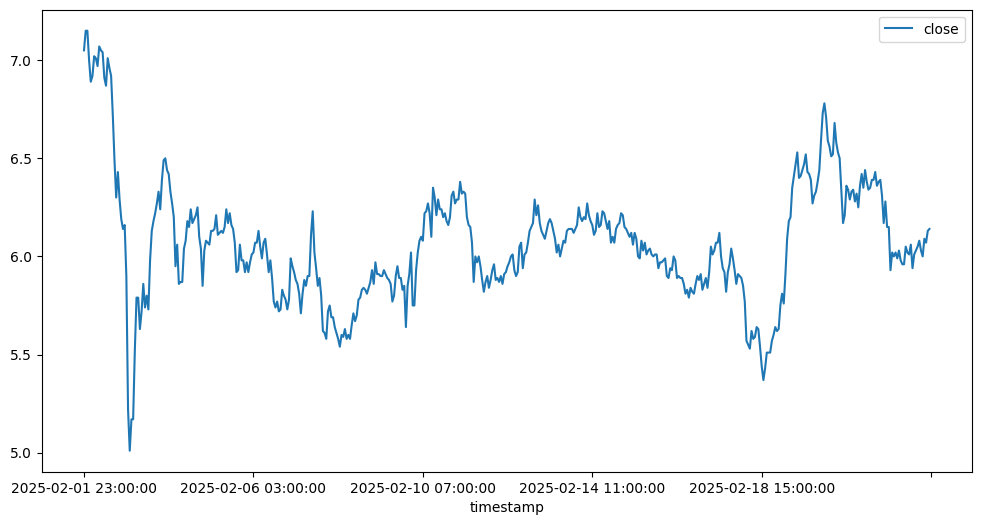

In [9]:
df.plot(figsize=(12, 6))

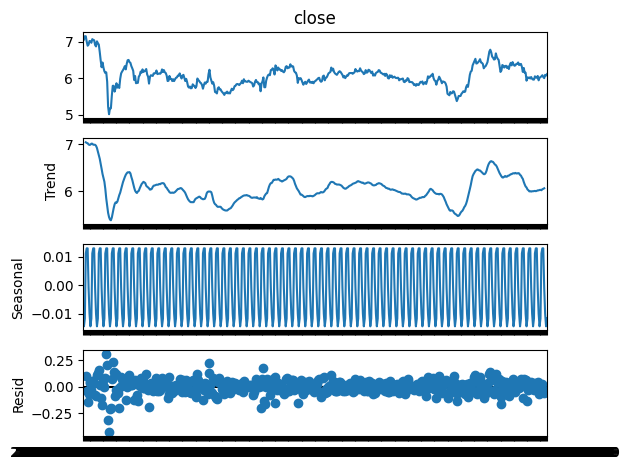

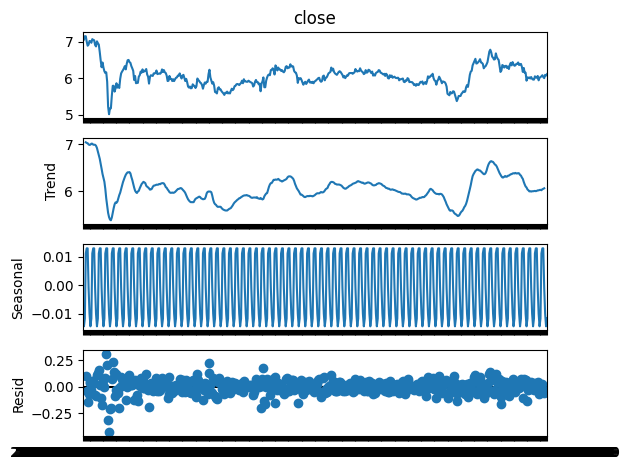

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['close'],period = 7)
results.plot()

Train,Test split and Normalization

In [18]:
train = df.iloc[:400]
test = df.iloc[400:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time series windows generation

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train,
								scaled_train,
								length=n_input,
								batch_size=1)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
# We do the same thing, but now instead for 12 months
n_input = 18
generator = TimeseriesGenerator(scaled_train,
								scaled_train,
								length=n_input,
								batch_size=1)

Given the Array: 
[0.95327103 1.         1.        ]
Predict this y: 
 [[0.92990654]]


Model architecture and Training

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

# Define how many past hours to look at
n_input = 12  # Using last 50 hours as input
n_future_hours = 5  # Predicting next 5 hours
n_features = 1  # We are only using 'close' prices

# Create the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),  # Another LSTM layer
    LSTM(50, activation='relu', return_sequences=False), 
    Dropout(0.2), # Last LSTM layer (return_sequences=False)
    Dense(n_future_hours)  # Output layer for multi-hour predictions
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

model.fit(generator, epochs=20)


C:\Users\Karan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,655 (592.40 KB)

 Trainable params: 151,655 (592.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


C:\Users\Karan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0481
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0083
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0131
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0084
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0066
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0059
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0046
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0072
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0047
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0041
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0029
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0026
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0033
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0022
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step 

In [13]:
model.save("LSTM_more_model.keras")

Testing

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Inverse transform predictions (reshape properly for multi-hour predictions)

test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)


predictions = model.predict(test_generator)

# print((predictions))

predictions_original = scaler.inverse_transform(predictions)

# Ensure predictions match the expected shape (88, 5)
predictions_original = predictions_original.reshape(-1, 5)

# Initialize a list to store errors
mse_list = []

# Loop through each row of predictions
for i in range(len(predictions_original)):  
    actual_values = test['close'].iloc[i + n_input : i + n_input + n_future_hours].values  # Get corresponding actual values
    predicted_values = predictions_original[i]  # Get predicted values

    if len(actual_values) == n_future_hours:  # Ensure we have enough data points
        mse = mean_squared_error(actual_values, predicted_values)
        mse_list.append(mse)

# Compute final RMSE
rmse = np.sqrt(np.mean(mse_list))

print(f"RMSE for multi-hour predictions: {rmse:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE for multi-hour predictions: 0.1749


Plotting the predictions

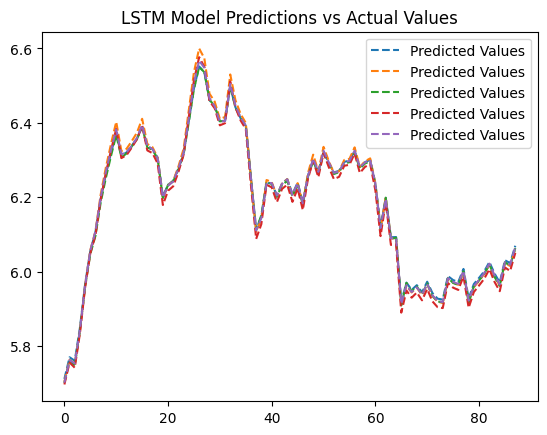

In [26]:
import matplotlib.pyplot as plt

# print(len(test['close']))
# print(len(predictions_original))
# plt.figure(figsize=(10, 5))
# plt.plot(test[11:16], label="Actual Values")
plt.plot(predictions_original, label="Predicted Values", linestyle="dashed")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

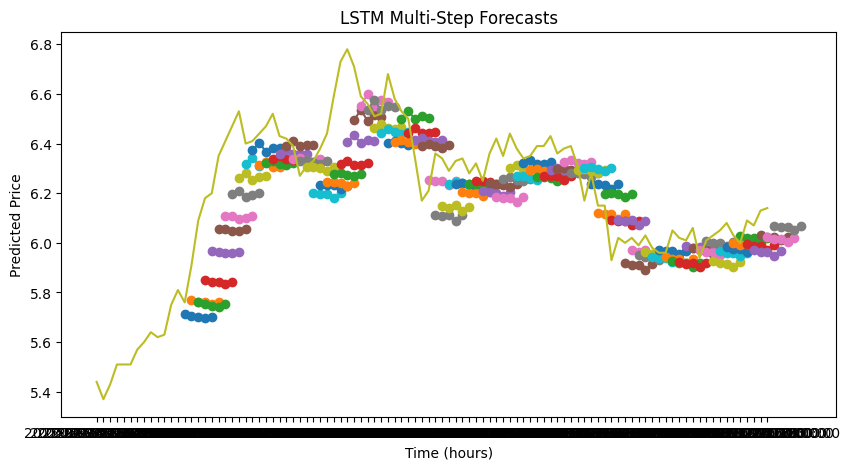

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

for i in range(len(predictions_original)):
    future_timestamps = np.arange(i + 13, i + 18)  # Align future steps
    plt.plot(future_timestamps, predictions_original[i], marker="o")



plt.xlabel("Time (hours)")
plt.ylabel("Predicted Price")
plt.title("LSTM Multi-Step Forecasts")
plt.show()


In [33]:
print(predictions_original[len(predictions_original)-1])

[6.069489  6.062094  6.0632772 6.0504217 6.06594  ]


This is the only block to be run when user wants

In [41]:
import ccxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load the pre-trained LSTM model
model = load_model("LSTM_more_model.keras")

# Initialize exchange
exchange = ccxt.binance()
symbol = 'APT/USDT'
timeframe = '1h'
n_input = 50  # The number of past time steps needed

# Fetch the last 50 OHLCV data points
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=n_input)

# Convert to DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Extract only 'close' prices
window = df['close'].values.reshape(-1, 1)  # Shape required for LSTM

# Load the same scaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))  
scaler.fit(window)  # Fit scaler on the new window

# Scale data
scaled_input = scaler.transform(window)

# Reshape to match LSTM input shape (batch_size=1, timesteps=50, features=1)
scaled_window = scaled_input.reshape(1, n_input, 1)

# Make a prediction
predicted_price_scaled = model.predict(scaled_window)

# Inverse transform to get the actual price
predicted_prices = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))
print(len(predicted_prices))
# Print prediction
print(predicted_prices)
# print(f"Predicted price for the next hour: {predicted_prices:.2f} USDT")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
5
[[6.008113 ]
 [6.003051 ]
 [5.999988 ]
 [6.000937 ]
 [6.0081115]]


In [11]:
# Load saved LSTM model
model = tf.keras.models.load_model("LSTM_more_model.keras")

# Define constants
symbol = 'APT/USDT'
timeframe = '1h'
n_input = 18  # Number of past hours to consider
n_future_hours = 5  # Predict next 5 hours

# Function to fetch latest data
def get_latest_data():
    exchange = ccxt.binance()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=n_input)
    
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    return df['close'].values.reshape(-1, 1)  # Extract close prices

window = get_latest_data()
print(window[len(window) - 1,0])


6.15
